In [2]:
import numpy as np
import ehtim as eh
from dataclasses import dataclass
from typing import Sequence, Optional, Dict
from scipy.optimize import least_squares

# =========================
# Unidades
# =========================
RADPERUAS = eh.RADPERUAS
RADPERMAS = RADPERUAS * 1e3  # rad/mas

def mas_to_rad(x_mas): return x_mas * RADPERMAS
def rad_to_mas(x_rad): return x_rad / RADPERMAS

FWHM_TO_SIGMA = 1.0 / (2.0*np.sqrt(2.0*np.log(2.0)))


uvfits_86 = "1253-055.W.2020-11-01.UVPN"
uvfits_43 = "1253-055.Q.2020-11-01.UVP"
uvfits_15 = "1253-055.u.2020_11_02.uvf"

freqs_ghz = np.array([86.0, 43.0, 15.0], dtype=float)
nu0_ghz = 86.0

In [ ]:
obs_by_freq: Dict[float, eh.obsdata.Obsdata] = {}
data_by_freq = {}

for f, path in zip(freqs_ghz, [uvfits_86, uvfits_43, uvfits_15]):
    obs = eh.obsdata.load_uvfits(path)
    obs_by_freq[f] = obs

    u = obs.data["u"]         
    v = obs.data["v"]         
    vis = obs.data["vis"]     
    sigma = obs.data["sigma"]  

    data_by_freq[f] = dict(u=u, v=v, vis=vis, sigma=sigma)

def gaussian_vis_circ(u_lam, v_lam, F_jy, x_mas, y_mas, fwhm_mas):
    """u,v en lambda; x,y,fwhm en mas; F en Jy"""
    x = mas_to_rad(x_mas)
    y = mas_to_rad(y_mas)
    sigma_rad = mas_to_rad(fwhm_mas) * FWHM_TO_SIGMA

    rho2 = u_lam*u_lam + v_lam*v_lam
    gauss_factor = np.exp(-2.0*(np.pi**2)*(sigma_rad**2)*rho2)
    phase = np.exp(-2j*np.pi*(u_lam*x + v_lam*y))
    return F_jy * gauss_factor * phase

def flux_law(freq_ghz, A0, alpha, nu0_ghz):
    s = float(freq_ghz)/float(nu0_ghz)
    return A0 * s**alpha

def size_law(freq_ghz, th0, beta, nu0_ghz):
    s = float(freq_ghz)/float(nu0_ghz)
    return th0 * s**beta

def core_pos_law(freq_ghz, x0, y0, Kx, Ky, nu0_ghz):
    # Kx,Ky en mas*GHz, devuelve mas
    inv = (1.0/float(freq_ghz) - 1.0/float(nu0_ghz))
    return x0 + Kx*inv, y0 + Ky*inv





@dataclass
class KnotSeed:
    A0_jy: float
    alpha: float
    fwhm_mas: float
    x_phys_mas: float
    y_phys_mas: float

@dataclass
class CoreSeed:
    A0_jy: float
    alpha: float
    fwhm0_mas: float
    beta: float
    x0_mas: float
    y0_mas: float
    Kx_masGHz: float
    Ky_masGHz: float

def pack_params(core: CoreSeed, knots: Sequence[KnotSeed], freqs_ghz, nu0_ghz):
    p = []
    # core (global)
    p += [core.A0_jy, core.alpha, core.fwhm0_mas, core.beta,
          core.x0_mas, core.y0_mas, core.Kx_masGHz, core.Ky_masGHz]
    # knots (global)
    for k in knots:
        p += [k.A0_jy, k.alpha, k.fwhm_mas, k.x_phys_mas, k.y_phys_mas]
    # shifts Dx,Dy per freq != nu0
    for f in freqs_ghz:
        if np.isclose(f, nu0_ghz):
            continue
        p += [0.0, 0.0]  # Dx_f, Dy_f ini
    return np.array(p, dtype=float)

def unpack_params(p, n_knots, freqs_ghz, nu0_ghz):
    i = 0
    A0c = p[i]; i+=1
    alc = p[i]; i+=1
    th0c = p[i]; i+=1
    btc = p[i]; i+=1
    x0c = p[i]; i+=1
    y0c = p[i]; i+=1
    Kx  = p[i]; i+=1
    Ky  = p[i]; i+=1

    knots = []
    for _ in range(n_knots):
        A0 = p[i]; i+=1
        al = p[i]; i+=1
        th = p[i]; i+=1
        x  = p[i]; i+=1
        y  = p[i]; i+=1
        knots.append((A0, al, th, x, y))

    Dx = {}; Dy = {}
    for f in freqs_ghz:
        if np.isclose(f, nu0_ghz):
            Dx[f] = 0.0
            Dy[f] = 0.0
        else:
            Dx[f] = p[i]; i+=1
            Dy[f] = p[i]; i+=1

    core = dict(A0=A0c, alpha=alc, th0=th0c, beta=btc, x0=x0c, y0=y0c, Kx=Kx, Ky=Ky)
    return core, knots, Dx, Dy

def model_vis_for_freq(p, n_knots, freq_ghz, freqs_ghz, nu0_ghz, u, v):
    core, knots, Dx, Dy = unpack_params(p, n_knots, freqs_ghz, nu0_ghz)

    # shifts 
    dx = Dx[freq_ghz]
    dy = Dy[freq_ghz]

    Fc   = flux_law(freq_ghz, core["A0"], core["alpha"], nu0_ghz)
    thc  = size_law(freq_ghz, core["th0"], core["beta"], nu0_ghz)
    xc_phys, yc_phys = core_pos_law(freq_ghz, core["x0"], core["y0"], core["Kx"], core["Ky"], nu0_ghz)
    xc_map = xc_phys - dx
    yc_map = yc_phys - dy

    V = gaussian_vis_circ(u, v, Fc, xc_map, yc_map, thc)


    for (A0, al, th, xphys, yphys) in knots:
        Fk = flux_law(freq_ghz, A0, al, nu0_ghz)
        xmap = xphys - dx
        ymap = yphys - dy
        V += gaussian_vis_circ(u, v, Fk, xmap, ymap, th)

    return V

def residuals_global(p, n_knots, freqs_ghz, nu0_ghz, data_by_freq):
    res_all = []
    for f in freqs_ghz:
        u = data_by_freq[f]["u"]
        v = data_by_freq[f]["v"]
        vis = data_by_freq[f]["vis"]
        sig = data_by_freq[f]["sigma"]

        Vmod = model_vis_for_freq(p, n_knots, f, freqs_ghz, nu0_ghz, u, v)
        r = (vis - Vmod) / sig
        res_all.append(r.real)
        res_all.append(r.imag)
    return np.concatenate(res_all)


n_knots = 3

# Core guess a 86 GHz
core0 = CoreSeed(
    A0_jy=8.6,
    alpha=0.0,
    fwhm0_mas=0.06,
    beta=0.0,         
    x0_mas=0.0,
    y0_mas=0.0,
    Kx_masGHz=0.0,    
    Ky_masGHz=0.0
)

# Knots guess ( 86 ref)
knots0 = [
    KnotSeed(A0_jy=3.7, alpha=-0.7, fwhm_mas=0.09, x_phys_mas=0.19*np.sin(-146*np.pi/180), y_phys_mas=0.19*np.cos(-146*np.pi/180)),
    KnotSeed(A0_jy=1.6, alpha=-0.7, fwhm_mas=0.17, x_phys_mas=0.63*np.sin(-144*np.pi/180), y_phys_mas=0.63*np.cos(-144*np.pi/180)),
    KnotSeed(A0_jy=0.5, alpha=-0.7, fwhm_mas=0.39, x_phys_mas=0.97*np.sin(-139*np.pi/180), y_phys_mas=0.97*np.cos(-139*np.pi/180)),
]

p0 = pack_params(core0, knots0, freqs_ghz, nu0_ghz)

# BOUNDS (físicos)
lb = np.full_like(p0, -np.inf)
ub = np.full_like(p0,  np.inf)

# core: 0..7
idx_core_A0 = 0
idx_core_al = 1
idx_core_th0= 2
idx_core_bt = 3
idx_core_x0 = 4
idx_core_y0 = 5
idx_core_Kx = 6
idx_core_Ky = 7

# CORE FLUX/SIZE > 0
lb[idx_core_A0]  = 0.0
lb[idx_core_th0] = 0.0

# TYPICAL RANGES (adjust to your needs) 
lb[idx_core_al] = -3.0; ub[idx_core_al] = 2.0
lb[idx_core_bt] = -5.0; ub[idx_core_bt] = 5.0

# POSITIONS CORE(86) IN FIELD (mas)
pos_absmax_mas = 2.0
lb[idx_core_x0] = -pos_absmax_mas; ub[idx_core_x0] = pos_absmax_mas
lb[idx_core_y0] = -pos_absmax_mas; ub[idx_core_y0] = pos_absmax_mas

# Kx,Ky bounds (mas*GHz)
Kmax = 10.0  # mas*GHz
lb[idx_core_Kx] = -Kmax; ub[idx_core_Kx] = Kmax
lb[idx_core_Ky] = -Kmax; ub[idx_core_Ky] = Kmax

# knots: bloques de 5
base = 8
for j in range(n_knots):
    A0i = base + 5*j + 0
    ali = base + 5*j + 1
    thi = base + 5*j + 2
    xi  = base + 5*j + 3
    yi  = base + 5*j + 4

    lb[A0i] = 0.0
    lb[thi] = 0.0
    lb[ali] = -3.0; ub[ali] = 2.0
    lb[xi]  = -pos_absmax_mas; ub[xi] = pos_absmax_mas
    lb[yi]  = -pos_absmax_mas; ub[yi] = pos_absmax_mas

nshift = 2*(len(freqs_ghz)-1)
shift_start = len(p0) - nshift
lb[shift_start:] = -pos_absmax_mas
ub[shift_start:] =  pos_absmax_mas


res = least_squares(
    residuals_global,
    x0=p0,
    bounds=(lb, ub),
    args=(n_knots, freqs_ghz, nu0_ghz, data_by_freq),
    method="trf",
    x_scale="jac",
    verbose=2,
    max_nfev=200
)

p_best = res.x
chi2 = np.sum(res.fun**2)
ndof = len(res.fun) - len(p_best)
print("\nSuccess:", res.success)
print("Message:", res.message)
print("chi2 =", chi2, " ndof =", ndof, " red_chi2 ~", chi2/max(ndof,1))

# =========================
# 7) Reporte: flujos, tamaños, posiciones + shifts
# =========================
core_b, knots_b, Dx_b, Dy_b = unpack_params(p_best, n_knots, freqs_ghz, nu0_ghz)

print("\n=== SHIFTS por frecuencia (relativos a 86 GHz) ===")
for f in freqs_ghz:
    print(f"{f:5.1f} GHz : Dx={Dx_b[f]: .6f} mas  Dy={Dy_b[f]: .6f} mas")

print("\n=== KNOTS (posiciones físicas en el marco de 86 GHz) ===")
for j,(A0,al,th,x,y) in enumerate(knots_b, start=1):
    print(f"K{j}: x_phys={x: .6f} mas  y_phys={y: .6f} mas  fwhm={th: .6f} mas  A0(86)={A0:.3f} Jy  alpha={al:.3f}")

print("\n=== DERIVADOS por frecuencia ===")
for f in freqs_ghz:
    dx, dy = Dx_b[f], Dy_b[f]

    Fc  = flux_law(f, core_b["A0"], core_b["alpha"], nu0_ghz)
    thc = size_law(f, core_b["th0"], core_b["beta"], nu0_ghz)
    xc_phys, yc_phys = core_pos_law(f, core_b["x0"], core_b["y0"], core_b["Kx"], core_b["Ky"], nu0_ghz)
    xc_map, yc_map = xc_phys - dx, yc_phys - dy

    print(f"\n{f:5.1f} GHz | CORE map: x={xc_map: .6f} mas  y={yc_map: .6f} mas  fwhm={thc:.6f} mas  F={Fc:.3f} Jy")

    for j,(A0,al,th,xphys,yphys) in enumerate(knots_b, start=1):
        Fk = flux_law(f, A0, al, nu0_ghz)
        xmap, ymap = xphys - dx, yphys - dy
        print(f"         K{j} map:  x={xmap: .6f} mas  y={ymap: .6f} mas  fwhm={th:.6f} mas  F={Fk:.3f} Jy")


Welcome to eht-imaging! v 1.2.10 

Loading uvfits:  1253-055.W.2020-11-01.UVPN
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Warning! ignoring nonzero header PZERO values for DATE. Check your observation mjd/times!
No NX table in uvfits!
Loading uvfits:  1253-055.Q.2020-11-01.UVP
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Warning! ignoring nonzero header PZERO values for DATE. Check your observation mjd/times!
No NX table in uvfits!
Loading uvfits:  1253-055.u.2020_11_02.uvf
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Warning! ignoring nonzero header PZERO values for DATE. Check your observation mjd/times!
No NX table in uvfits!
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.6203e+08                                    2.02e+09    
       1              2         2.8908e+07      2.33e+08       1.42e+00       5.00e+08    
       2              3         1.1497e+

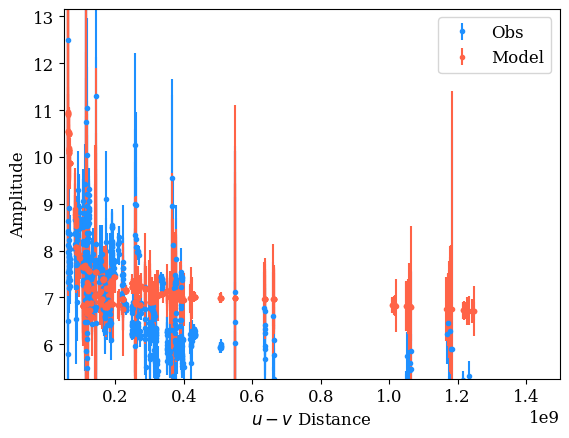

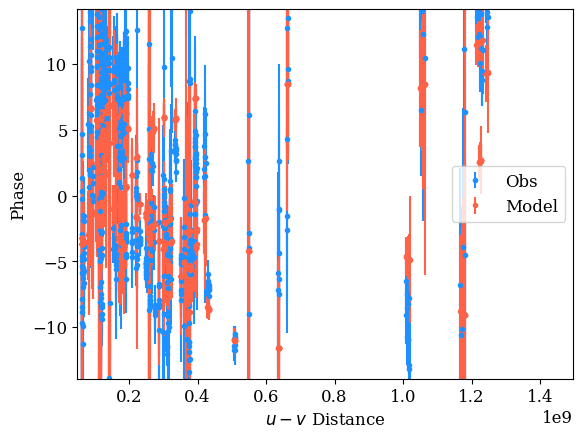

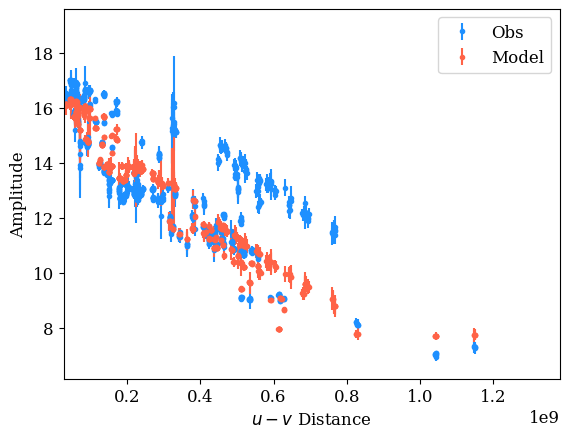

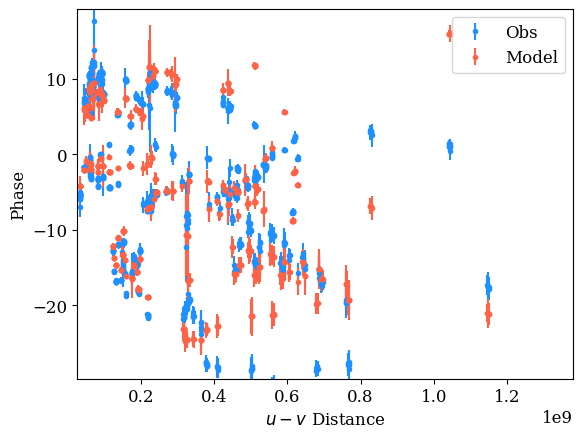

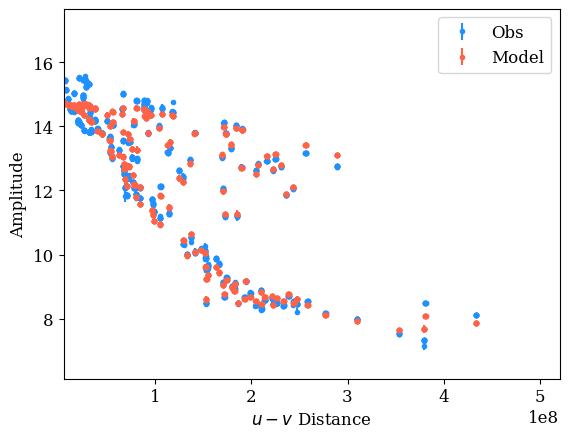

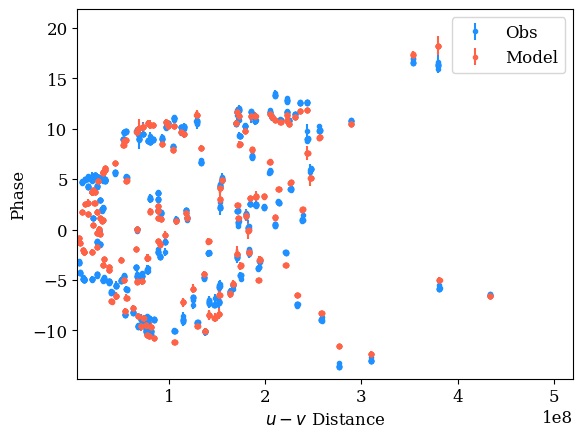

In [3]:
for f in freqs_ghz:
    obs = obs_by_freq[f]
    u = data_by_freq[f]["u"]; v = data_by_freq[f]["v"]
    Vbest = model_vis_for_freq(p_best, n_knots, f, freqs_ghz, nu0_ghz, u, v)

    obs_model = obs.copy()
    obs_model.data["vis"] = Vbest

    eh.plotall_obs_compare([obs, obs_model], "uvdist", "amp", legendlabels=["Obs","Model"])
    eh.plotall_obs_compare([obs, obs_model], "uvdist", "phase", legendlabels=["Obs","Model"])
